# Requerimiento de Capital Mensual para el Portafolio

## Objetivo
Calcular el requerimiento de capital mensual basado en la distribucion de perdida agregada total del modelo de riesgo colectivo.

In [16]:
# Librerias necesarias
library(data.table)
library(ggplot2)
library(knitr)

# Cargar datos de perdida agregada total
perdida_total <- fread("../data/output/perdida_agregada_total_portafolio.csv")

# Verificar estructura de datos
cat("Estructura de datos cargados:")
cat("\nTotal de observaciones:", nrow(perdida_total))
cat("\nRango de perdidas: [", min(perdida_total$x), ",", max(perdida_total$x), "]")
cat("\nDiscretizacion: pasos de $10,000")
head(perdida_total, 10)

Estructura de datos cargados:
Total de observaciones: 200001
Rango de perdidas: [ 0 , 2e+09 ]
Discretizacion: pasos de $10,000

x,pmf,cdf
<dbl>,<dbl>,<dbl>
0,3.133502e-02,0.03133502
10000,1.079546e-05,0.03134581
20000,1.515316e-05,0.03136097
30000,1.926327e-05,0.03138023
40000,2.324601e-05,0.03140348
50000,2.718288e-05,0.03143066
60000,3.113151e-05,0.03146179
70000,3.513098e-05,0.03149692
80000,3.920554e-05,0.03153613


In [17]:
# Calcular estadisticas basicas
perdida_esperada <- sum(perdida_total$x * perdida_total$pmf)
segundo_momento <- sum(perdida_total$x^2 * perdida_total$pmf)
varianza <- segundo_momento - perdida_esperada^2
desviacion_estandar <- sqrt(varianza)
cv <- desviacion_estandar / perdida_esperada

# Crear tabla de estadisticas descriptivas
estadisticas <- data.frame(
  Metrica = c("Perdida Esperada", "Desviacion Estandar", "Varianza", "Coeficiente de Variacion"),
  Valor = c(
    paste0("$", format(perdida_esperada, big.mark=",", scientific=FALSE)),
    paste0("$", format(desviacion_estandar, big.mark=",", scientific=FALSE)),
    paste0("$", format(varianza, big.mark=",", scientific=TRUE)),
    paste0(round(cv, 4))
  )
)

kable(estadisticas, caption = "Estadisticas Descriptivas de la Perdida Agregada")
cat("\n\nResumen: La perdida esperada mensual es de $", format(perdida_esperada, big.mark=",", scientific=FALSE))



Table: Estadisticas Descriptivas de la Perdida Agregada

|Metrica                  |Valor         |
|:------------------------|:-------------|
|Perdida Esperada         |$12,719,851   |
|Desviacion Estandar      |$10,718,544   |
|Varianza                 |$1.148872e+14 |
|Coeficiente de Variacion |0.8427        |



Resumen: La perdida esperada mensual es de $ 12,719,851

In [18]:
# Funcion para calcular VaR considerando la discretizacion
calcular_var <- function(datos, alpha) {
  indice <- which(datos$cdf >= alpha)[1]
  return(datos$x[indice])
}

# Calcular VaR para diferentes niveles de confianza
var_90 <- calcular_var(perdida_total, 0.90)
var_95 <- calcular_var(perdida_total, 0.95)
var_99 <- calcular_var(perdida_total, 0.99)
var_995 <- calcular_var(perdida_total, 0.995)
var_999 <- calcular_var(perdida_total, 0.999)

# Crear tabla de VaR
tabla_var <- data.frame(
  Nivel_Confianza = c("90%", "95%", "99%", "99.5%", "99.9%"),
  VaR = c(
    paste0("$", format(var_90, big.mark=",", scientific=FALSE)),
    paste0("$", format(var_95, big.mark=",", scientific=FALSE)),
    paste0("$", format(var_99, big.mark=",", scientific=FALSE)),
    paste0("$", format(var_995, big.mark=",", scientific=FALSE)),
    paste0("$", format(var_999, big.mark=",", scientific=FALSE))
  ),
  Probabilidad_Exceso = c("10%", "5%", "1%", "0.5%", "0.1%")
)

kable(tabla_var, caption = "Value at Risk (VaR) - Perdidas Maximas por Nivel de Confianza")
cat("\n\nNota: VaR representa la perdida maxima esperada en el percentil dado")



Table: Value at Risk (VaR) - Perdidas Maximas por Nivel de Confianza

|Nivel_Confianza |VaR         |Probabilidad_Exceso |
|:---------------|:-----------|:-------------------|
|90%             |$24,560,000 |10%                 |
|95%             |$30,830,000 |5%                  |
|99%             |$52,620,000 |1%                  |
|99.5%           |$64,850,000 |0.5%                |
|99.9%           |$94,070,000 |0.1%                |



Nota: VaR representa la perdida maxima esperada en el percentil dado

In [19]:
# Calcular Solvency Capital Requirement (SCR) - Requerimiento de Capital\nscr <- var_995 - perdida_esperada\nscr_porcentaje <- (scr / perdida_esperada) * 100\nmultiplo_std <- scr / desviacion_estandar\n\n# Calcular otros SCR alternativos\nscr_99 <- var_99 - perdida_esperada\nscr_999 <- var_999 - perdida_esperada\n\n# Tabla de requerimientos de capital\ntabla_scr <- data.frame(\n  Nivel_Confianza = c(\"99%\", \"99.5% (Solvencia II)\", \"99.9%\"),\n  VaR = c(\n    paste0(\"$\", format(var_99, big.mark=\",\", scientific=FALSE)),\n    paste0(\"$\", format(var_995, big.mark=\",\", scientific=FALSE)),\n    paste0(\"$\", format(var_999, big.mark=\",\", scientific=FALSE))\n  ),\n  SCR = c(\n    paste0(\"$\", format(scr_99, big.mark=\",\", scientific=FALSE)),\n    paste0(\"$\", format(scr, big.mark=\",\", scientific=FALSE)),\n    paste0(\"$\", format(scr_999, big.mark=\",\", scientific=FALSE))\n  ),\n  Porcentaje_Perdida_Esperada = c(\n    paste0(round((scr_99/perdida_esperada)*100, 1), \"%\"),\n    paste0(round(scr_porcentaje, 1), \"%\"),\n    paste0(round((scr_999/perdida_esperada)*100, 1), \"%\")\n  )\n)\n\nkable(tabla_scr, caption = \"Solvency Capital Requirement (SCR) - Requerimiento de Capital\")\ncat(\"\\n\\nSCR = VaR - Perdida Esperada\")\ncat(\"\\nEl SCR al 99.5% representa\", round(multiplo_std, 2), \"desviaciones estandar\")\ncat(\"\\nEste es el capital adicional requerido por encima de la perdida esperada\")"

In [20]:
# Calcular Tail Conditional Expectation (TCE)
calcular_tce <- function(datos, var_level) {
  tail_data <- datos[x > var_level]
  prob_tail <- sum(tail_data$pmf)
  if(prob_tail > 0) {
    tail_data$pmf_norm <- tail_data$pmf / prob_tail
    tce <- sum(tail_data$x * tail_data$pmf_norm)
  } else {
    tce <- var_level
  }
  return(list(tce = tce, prob_tail = prob_tail))
}

# TCE para diferentes niveles
resultado_tce_995 <- calcular_tce(perdida_total, var_995)
resultado_tce_99 <- calcular_tce(perdida_total, var_99)
resultado_tce_999 <- calcular_tce(perdida_total, var_999)

# Tabla de TCE
tabla_tce <- data.frame(
  Nivel = c("99%", "99.5%", "99.9%"),
  VaR = c(
    paste0("$", format(var_99, big.mark=",", scientific=FALSE)),
    paste0("$", format(var_995, big.mark=",", scientific=FALSE)),
    paste0("$", format(var_999, big.mark=",", scientific=FALSE))
  ),
  TCE = c(
    paste0("$", format(resultado_tce_99$tce, big.mark=",", scientific=FALSE)),
    paste0("$", format(resultado_tce_995$tce, big.mark=",", scientific=FALSE)),
    paste0("$", format(resultado_tce_999$tce, big.mark=",", scientific=FALSE))
  ),
  Prob_Exceso = c(
    paste0(round(resultado_tce_99$prob_tail * 100, 3), "%"),
    paste0(round(resultado_tce_995$prob_tail * 100, 3), "%"),
    paste0(round(resultado_tce_999$prob_tail * 100, 3), "%")
  )
)

kable(tabla_tce, caption = "Tail Conditional Expectation (TCE) - Perdida Esperada en la Cola")
cat("\n\nTCE: Perdida esperada dado que se excede el VaR")



Table: Tail Conditional Expectation (TCE) - Perdida Esperada en la Cola

|Nivel |VaR         |TCE          |Prob_Exceso |
|:-----|:-----------|:------------|:-----------|
|99%   |$52,620,000 |$70,509,879  |1%          |
|99.5% |$64,850,000 |$83,022,982  |0.5%        |
|99.9% |$94,070,000 |$112,475,643 |0.1%        |



TCE: Perdida esperada dado que se excede el VaR

In [21]:
# Analisis del SCR como requerimiento de capital\n# El SCR representa el capital adicional necesario para eventos extremos\n\n# Comparar SCR con metricas de riesgo\ntabla_analisis <- data.frame(\n  Metrica = c(\n    \"Perdida Esperada\",\n    \"Desviacion Estandar\", \n    \"SCR (99.5%)\",\n    \"SCR como % de Perdida Esperada\",\n    \"SCR en multiplos de σ\"\n  ),\n  Valor = c(\n    paste0(\"$\", format(perdida_esperada, big.mark=\",\", scientific=FALSE)),\n    paste0(\"$\", format(desviacion_estandar, big.mark=\",\", scientific=FALSE)),\n    paste0(\"$\", format(scr, big.mark=\",\", scientific=FALSE)),\n    paste0(round(scr_porcentaje, 1), \"%\"),\n    paste0(round(multiplo_std, 2), \" σ\")\n  )\n)\n\nkable(tabla_analisis, caption = \"Analisis del Solvency Capital Requirement (SCR)\")\ncat(\"\\n\\nEl SCR es el capital adicional requerido para absorber perdidas extremas\")\ncat(\"\\ncon 99.5% de confianza, por encima de la perdida esperada.\")"



Grafico: Muestra la distribucion de perdidas con las principales metricas de riesgo

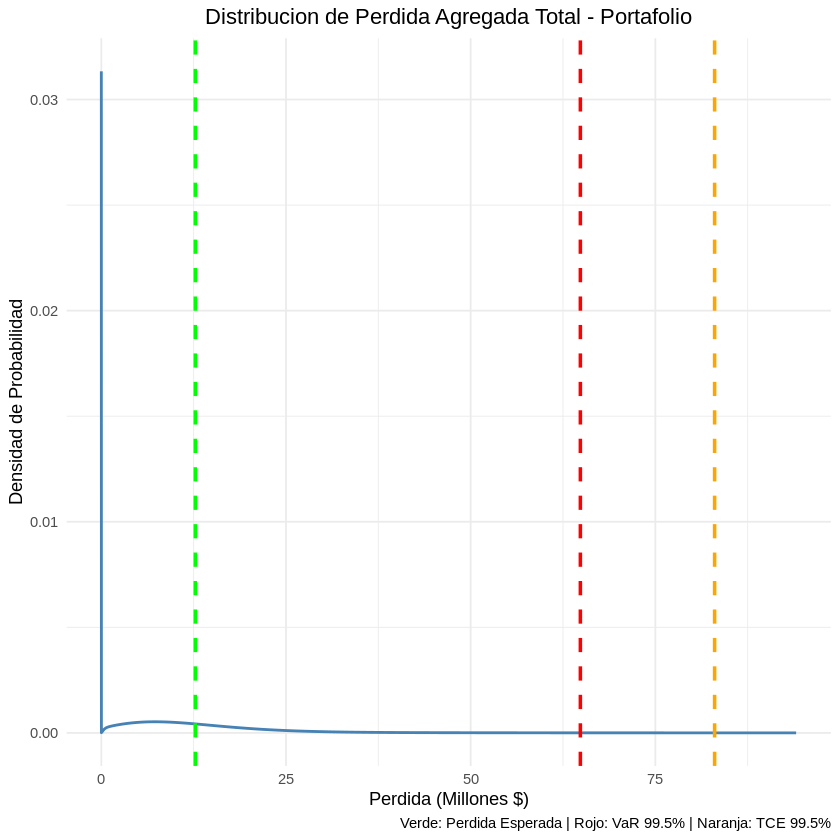

In [22]:
# Visualizacion de la distribucion con metricas de riesgo
# Filtrar datos para visualizacion (hasta percentil 99.9)
datos_plot <- perdida_total[cdf <= 0.999]

p1 <- ggplot(datos_plot, aes(x = x/1e6, y = pmf)) +
  geom_line(color = "steelblue", size = 0.8) +
  geom_vline(xintercept = perdida_esperada/1e6, color = "green", linetype = "dashed", size = 1) +
  geom_vline(xintercept = var_995/1e6, color = "red", linetype = "dashed", size = 1) +
  geom_vline(xintercept = resultado_tce_995$tce/1e6, color = "orange", linetype = "dashed", size = 1) +
  labs(
    title = "Distribucion de Perdida Agregada Total - Portafolio",
    x = "Perdida (Millones $)",
    y = "Densidad de Probabilidad",
    caption = "Verde: Perdida Esperada | Rojo: VaR 99.5% | Naranja: TCE 99.5%"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

print(p1)

cat("\n\nGrafico: Muestra la distribucion de perdidas con las principales metricas de riesgo")

## Respuesta: Requerimiento de Capital Mensual

### Resultado Principal

In [ ]:
# RESPUESTA FINAL - Requerimiento de Capital Mensual\ncat(\"======================================================\")\ncat(\"\\n       REQUERIMIENTO DE CAPITAL MENSUAL\")\ncat(\"\\n======================================================\")\ncat(\"\\n\")\ncat(\"\\nSegun las regulaciones de Solvencia II (VaR 99.5%):\")\ncat(\"\\n\")\ncat(\"\\n• PERDIDA ESPERADA:\")\ncat(\"\\n  $\", format(perdida_esperada, big.mark=\",\", scientific=FALSE))\ncat(\"\\n\")\ncat(\"\\n• SOLVENCY CAPITAL REQUIREMENT (SCR):\")\ncat(\"\\n  $\", format(scr, big.mark=\",\", scientific=FALSE))\ncat(\"\\n  (\", round(scr_porcentaje, 1), \"% adicional sobre perdida esperada)\")\ncat(\"\\n\")\ncat(\"\\n======================================================\")\ncat(\"\\n\")\ncat(\"\\nEl REQUERIMIENTO DE CAPITAL MENSUAL para el nuevo\")\ncat(\"\\nportafolio de seguros es de:\")\ncat(\"\\n\")\ncat(\"\\n        $\", format(scr, big.mark=\",\", scientific=FALSE))\ncat(\"\\n\")\ncat(\"\\n======================================================\")\ncat(\"\\n\")\ncat(\"\\nNota: Este es el capital adicional requerido por encima\")\ncat(\"\\nde la perdida esperada para cubrir eventos extremos\")\ncat(\"\\ncon 99.5% de confianza segun regulaciones de solvencia.\")\n\n# Tabla final resumen simplificada\nrespuesta_final <- data.frame(\n  Concepto = c(\"Perdida Esperada\", \"Requerimiento de Capital (SCR)\"),\n  Monto = c(\n    paste0(\"$\", format(perdida_esperada, big.mark=\",\", scientific=FALSE)),\n    paste0(\"$\", format(scr, big.mark=\",\", scientific=FALSE))\n  ),\n  Descripcion = c(\n    \"Perdidas esperadas del portafolio\",\n    \"Capital adicional para eventos extremos\"\n  )\n)\n\ncat(\"\\n\\nRESUMEN:\")\nkable(respuesta_final)"